In [27]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Device:", device)

X, y = make_moons(1000, noise=0.05, random_state=42)

size = int(0.8*len(X))

X_train, y_train = X[:size], y[:size]
X_test, y_test = X[size:], y[size:]

Device: cpu


In [28]:
len(X_train), len(X_test)

(800, 200)

In [29]:
X_train.shape

(800, 2)

In [30]:
from torch import nn
class MoonModel(nn.Module):
  def __init__(self, in_features, out_features, hidden_units):
    super().__init__()

    self.layer1 = nn.Linear(in_features=in_features,
                            out_features=hidden_units)
    self.layer2 = nn.Linear(in_features=hidden_units,
                            out_features=hidden_units)
    self.layer3 = nn.Linear(in_features=hidden_units,
                            out_features=out_features)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model = MoonModel(in_features=2,
                  out_features=1,
                  hidden_units=10).to(device)
model

MoonModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [31]:
model.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5167, -0.6792],
                      [ 0.3829,  0.3425],
                      [ 0.0052,  0.4972],
                      [-0.1683, -0.3981],
                      [-0.2446, -0.5403],
                      [-0.6354, -0.2091],
                      [ 0.0775,  0.2991],
                      [ 0.5749, -0.3538],
                      [-0.1295,  0.5179],
                      [-0.1645, -0.3630]])),
             ('layer1.bias',
              tensor([ 0.0531, -0.1582, -0.1375, -0.2181,  0.1236, -0.5917, -0.3024, -0.3587,
                      -0.4511, -0.3302])),
             ('layer2.weight',
              tensor([[-9.9900e-02, -1.1425e-01, -5.1696e-02, -1.3829e-01, -1.8767e-01,
                       -2.5939e-01, -2.1679e-01, -2.2208e-01,  1.8873e-01,  8.2229e-04],
                      [-2.0472e-01, -2.3166e-02, -6.8319e-02, -1.2209e-01, -2.9477e-01,
                       -2.8133e-01,  1.2119e-01,  6.9977e-02,  1.5761e-01, -1.0890e-

In [32]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

In [33]:
!pip install torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device)
acc_fn

MulticlassAccuracy()

In [34]:
X_train, y_train = torch.tensor(X_train, dtype=torch.float).to(device), torch.tensor(y_train, dtype=torch.float).to(device)
X_test, y_test = torch.tensor(X_test, dtype=torch.float).to(device), torch.tensor(y_test, dtype=torch.float).to(device)

epochs = 1000

for epoch in range(epochs):
  model.train()

  y_logits = model(X_train).squeeze()

  y_pred_probs = torch.sigmoid(y_logits)

  y_pred = torch.round(y_pred_probs)

  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train.int())

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model.eval()

  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test.int())

  if epoch % 100 == 0:
    print(f"Epoch : {epoch} | Loss : {loss:.2f} | Test Loss: {test_loss:.2f} | Test Accuracy: {test_acc:.2f}")

Epoch : 0 | Loss : 0.73 | Test Loss: 0.72 | Test Accuracy: 0.50
Epoch : 100 | Loss : 0.41 | Test Loss: 0.42 | Test Accuracy: 0.81
Epoch : 200 | Loss : 0.24 | Test Loss: 0.26 | Test Accuracy: 0.89
Epoch : 300 | Loss : 0.20 | Test Loss: 0.23 | Test Accuracy: 0.90
Epoch : 400 | Loss : 0.17 | Test Loss: 0.20 | Test Accuracy: 0.92
Epoch : 500 | Loss : 0.13 | Test Loss: 0.15 | Test Accuracy: 0.94
Epoch : 600 | Loss : 0.09 | Test Loss: 0.10 | Test Accuracy: 0.96
Epoch : 700 | Loss : 0.05 | Test Loss: 0.06 | Test Accuracy: 0.98
Epoch : 800 | Loss : 0.03 | Test Loss: 0.04 | Test Accuracy: 0.99
Epoch : 900 | Loss : 0.02 | Test Loss: 0.03 | Test Accuracy: 1.00


In [35]:
import numpy as np

def plot_decision_boundary(model, X, y):

    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

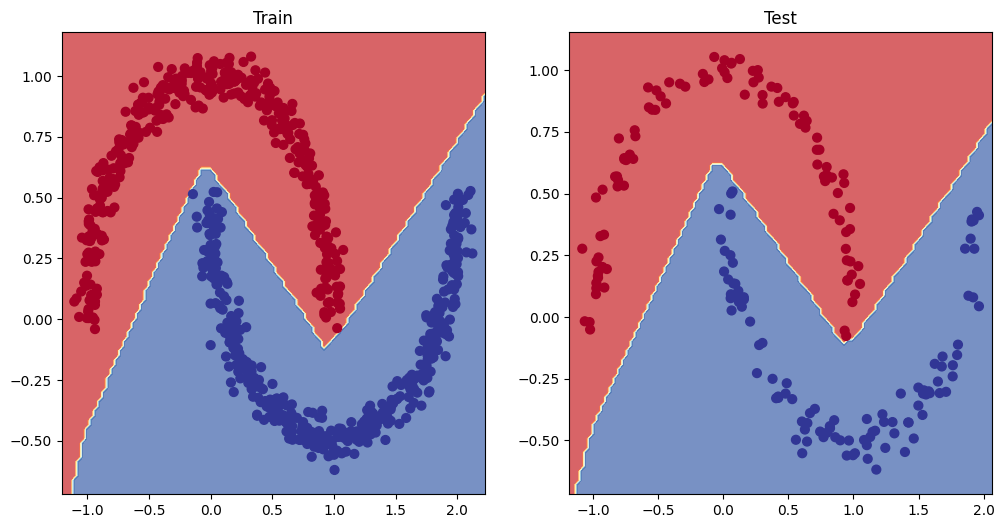

In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

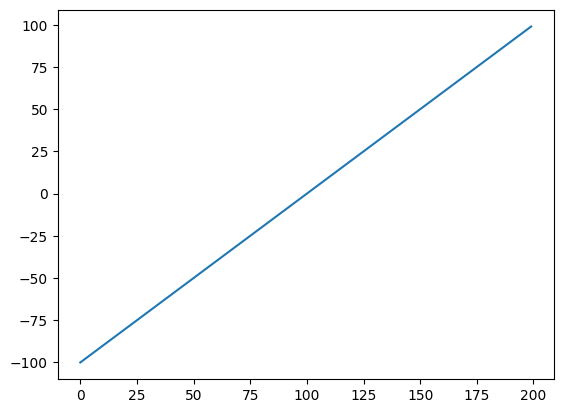

In [37]:
tensor_A = torch.arange(-100, 100, 1)
plt.plot(tensor_A)

In [38]:
def tanh(z):
  return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

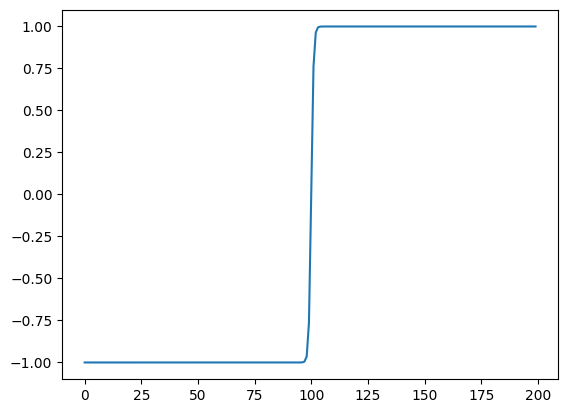

In [39]:
plt.plot(tanh(tensor_A))

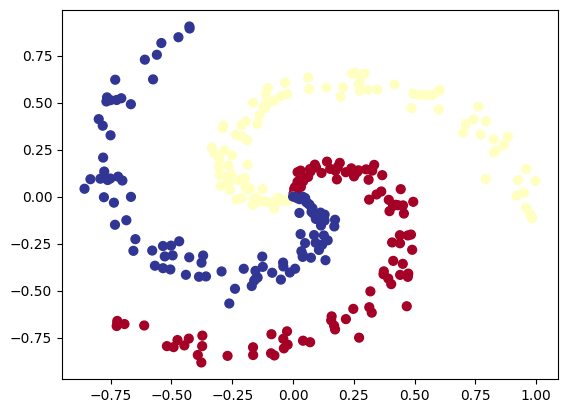

In [40]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100
D = 2
K = 3
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [41]:
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [42]:
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device)
acc_fn

MulticlassAccuracy()

In [43]:
class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=2,
                            out_features=10)
    self.layer2 = nn.Linear(in_features=10,
                            out_features=10)
    self.layer3 = nn.Linear(in_features=10,
                            out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

spiral_model = SpiralModel()

In [44]:
spiral_model

SpiralModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [46]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

print("Logits:")
print(spiral_model(X_train)[:10])

print("Pred probs:")
print(torch.softmax(spiral_model(X_train)[:10], dim=1))

print("Pred labels:")
print(torch.softmax(spiral_model(X_train)[:10], dim=1).argmax(dim=1))

torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[ 0.1757, -0.2346,  0.3021],
        [ 0.2180, -0.2125,  0.2954],
        [ 0.1413, -0.2571,  0.3298],
        [ 0.2160, -0.1805,  0.3693],
        [ 0.1597, -0.2155,  0.4063],
        [ 0.1573, -0.2442,  0.3249],
        [ 0.1484, -0.2515,  0.3300],
        [ 0.1162, -0.2853,  0.3252],
        [ 0.2184, -0.2109,  0.2994],
        [ 0.2165, -0.1789,  0.3717]], grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.3574, 0.2371, 0.4055],
        [0.3662, 0.2381, 0.3957],
        [0.3474, 0.2332, 0.4194],
        [0.3523, 0.2370, 0.4107],
        [0.3371, 0.2316, 0.4313],
        [0.3506, 0.2347, 0.4147],
        [0.3485, 0.2336, 0.4179],
        [0.3446, 0.2307, 0.4247],
        [0.3656, 0.2380, 0.3964],
        [0.3519, 0.2370, 0.4111]], grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [48]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(spiral_model.parameters(),
                             lr=0.02)

In [49]:
epochs = 1000

for epoch in range(epochs):

  spiral_model.train()
  y_logits = spiral_model(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  spiral_model.eval()
  with torch.inference_mode():

    test_logits = spiral_model(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.13 Acc: 0.32 | Test loss: 1.07 Test acc: 0.37
Epoch: 100 | Loss: 0.19 Acc: 0.93 | Test loss: 0.16 Test acc: 0.93
Epoch: 200 | Loss: 0.05 Acc: 0.99 | Test loss: 0.03 Test acc: 1.00
Epoch: 300 | Loss: 0.03 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 400 | Loss: 0.03 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 500 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 600 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 700 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 800 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 900 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00


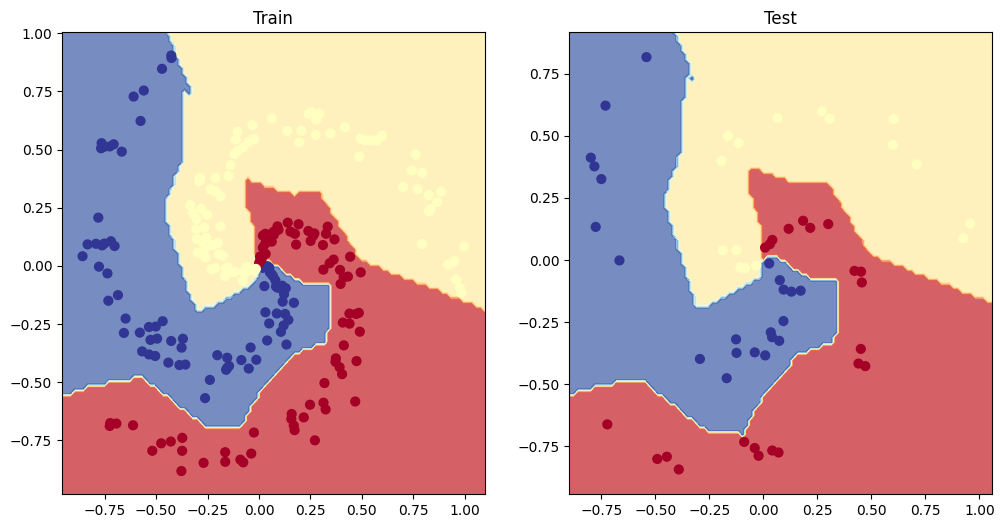

In [50]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(spiral_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(spiral_model, X_test, y_test)